# Ecological Data Science for Sustainable Agriculture (Part IV)

In [601]:
# Vector processing
import geopandas as gpd
import shapely
import osgb

# Raster processing
import rasterio
import rasterio.warp
import rasterio.mask
import rasterio.plot
import rasterio.features
import rasterio.sample
import rasterio.fill
from rasterio import windows
import pyproj
import xarray as xr
import rioxarray

# Calcs and modelling
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GroupKFold

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
from glob import glob
import warnings
import os
from pystac_client import Client
import boto3
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print
import subprocess
import functools
import sys
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

DATA_BASE_PATH = '../../../data/Agric_data/' # all data under this path (global)



In [2]:
with rasterio.open(os.path.join(DATA_BASE_PATH, 'IYR/data/input_to_yield_ratio_honeybees.tiff')) as file:
    iyr_bees = file.read(1)
    iyr_nodata = file.profile['nodata']
    WORKING_CRS = file.crs
    extent = [file.bounds.left, file.bounds.right, file.bounds.bottom, file.bounds.top]
    

iyr_bees = np.where(iyr_bees == iyr_nodata, np.nan, iyr_bees)

In [69]:
%matplotlib widget



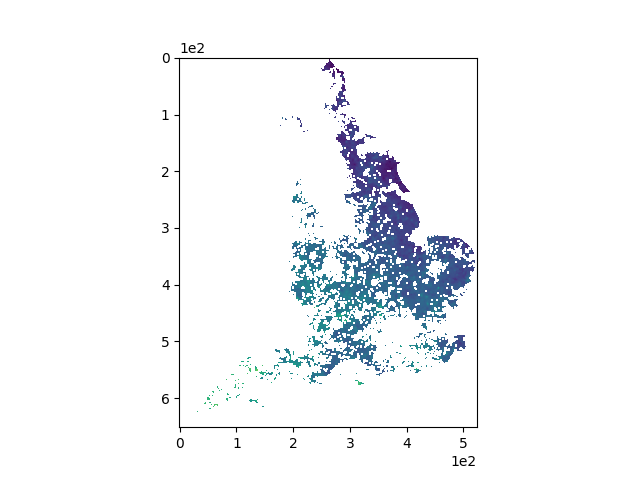

In [70]:


plt.figure()
plt.imshow(iyr_bees, interpolation=None)
plt.show()

In [4]:
sample_data = gpd.read_file(os.path.join(DATA_BASE_PATH, 'Pollinator_Fit_Counts/data/ukpoms_publicfitcountdata_2017-2020.csv' ), 
                             encoding='unicode_escape'
                           )

sample_data[['bumblebees',
'honeybees',
'solitary_bees',
'wasps',
'hoverflies',
'other_flies',
'butterflies_moths',
'beetles',
'insects_small',
'insects_other',
'all_insects_total',
'floral_unit_count']] = sample_data[['bumblebees',
                                        'honeybees',
                                        'solitary_bees',
                                        'wasps',
                                        'hoverflies',
                                        'other_flies',
                                        'butterflies_moths',
                                        'beetles',
                                        'insects_small',
                                        'insects_other',
                                        'all_insects_total',
                                        'floral_unit_count']].astype(int)
sample_data['month'] = sample_data['date'].str.split('/').str[1]

sample_data = sample_data[sample_data['country'] == 'England']

In [5]:

def parse_grid_handle_error(x1km_ref):
    try:
        return osgb.gridder.parse_grid(x1km_ref)

    except:
        return None


def grid_to_ll_handle_error(grid_ref):
    try:
        return osgb.grid_to_ll(grid_ref)

    except:
        return (np.nan, np.nan)



sample_data['X1km_centre'] = sample_data['X1km_square'].str[:4].str.cat(sample_data['X1km_square'].str[4:], sep='5') + '5'
sample_data['geometry'] = sample_data['X1km_centre'].apply(parse_grid_handle_error).apply(grid_to_ll_handle_error).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)



In [6]:
sample_data = sample_data[~sample_data['geometry'].is_empty]
sample_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)

In [7]:
sample_data

sample_id  country        date  year X1km_square sample_projection  \
0      3501506  England  05/05/2018  2018      SK3648              OSGB   
1      3493125  England  05/05/2018  2018      SK9482              OSGB   
2      3455170  England  05/05/2018  2018      SP0380              OSGB   
3      3455025  England  05/05/2018  2018      ST3109              OSGB   
4      3501609  England  19/05/2018  2018      SK3648              OSGB   
...        ...      ...         ...   ...         ...               ...   
3348   5619475  England  04/05/2019  2019      SK3648              OSGB   
3349   5600657  England  22/04/2019  2019      SK3584              OSGB   
3350   5600656  England  09/04/2019  2019      SK3584              OSGB   
3351   5579063  England  01/05/2019  2019      SJ8094              OSGB   
3352   5351009  England  11/04/2019  2019      SK3648              OSGB   

     digitised_by                                      recorder_type  \
0           86644  I am familiar with recognising the main groups...   
1          154133  I am familiar with identifying some wildlife g...   
2           73313  I am familiar with recognising the main groups...   
3          156295  I am familiar with recognising the main groups...   
4           86644  I am familiar with recognising the main groups...   
...           ...                                                ...   
3348        86644  I am familiar with recognising the main groups...   
3349       202018  I am confident in identifying the commonly-occ...   
3350       202018  I am confident in identifying the commonly-occ...   
3351        70693  I am familiar with identifying some wildlife g...   
3352        86644  I am familiar with recognising the main groups...   

                                        habitat habitat_other_detail  \
0                                        Garden                   NA   
1                                        Garden                   NA   
2                                        Garden                   NA   
3     Grassland with wild flowers (e.g. meadow)                   NA   
4                                        Garden                   NA   
...                                         ...                  ...   
3348                                     Garden                   NA   
3349                                     Garden                   NA   
3350                                     Garden                   NA   
3351                        Parkland with trees                   NA   
3352                                     Garden                   NA   

                         target_flower           target_flower_corrected  \
0     Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
1                 Hawthorn - Crataegus              Hawthorn - Crataegus   
2        Other - please describe below     Other - please describe below   
3       Buttercup (Ranunculus species)    Buttercup (Ranunculus species)   
4     Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
...                                ...                               ...   
3348  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3349  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3350  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3351  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3352  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   

     target_other_name target_other_name_corrected target_flower_family  \
0                   NA                          NA           Asteraceae   
1                   NA                          NA             Rosaceae   
2           Pulmonaria                  Pulmonaria         Boraginaceae   
3                   NA                          NA        Ranunculaceae   
4                   NA                          NA           Asteraceae   
...        

In [8]:
sample_data.geometry.duplicated().sum()

1987

In [9]:
extent

[132000.0, 656000.0, 6000.0, 658000.0]

In [10]:
WORKING_CRS

CRS.from_epsg(27700)

In [11]:
%matplotlib widget

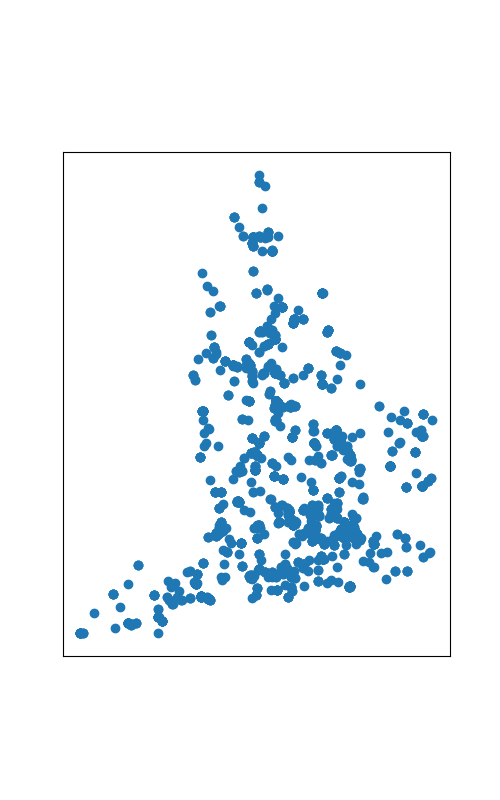

In [12]:


fig, ax= plt.subplots(figsize=(5, 8))

# ax.imshow(iyr_bees, interpolation=None, extent=extent)
sample_data.plot(ax=ax, )

ax.set_xticks([])
ax.set_yticks([])
plt.show()

honeybees    Axes(0.125,0.11;0.775x0.77)
dtype: object

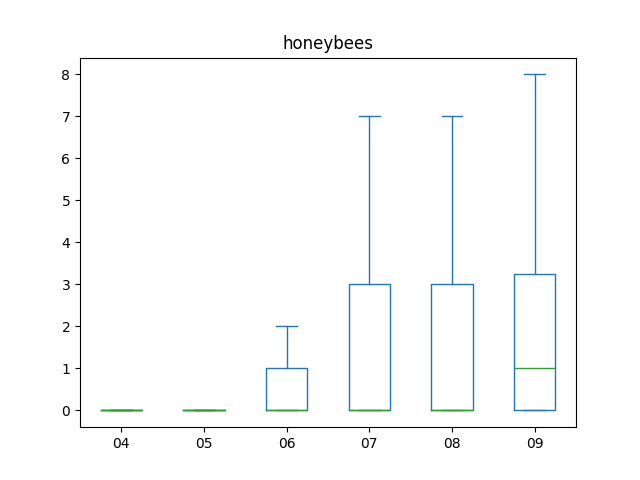

In [13]:
sample_data.plot.box(column='honeybees', by='month', sym='')

In [14]:
# There are many duplicate sampling locations (X1 squares) with different surveying metadata - how to handle this without chucking away useful data?
# Weight samples at the same location such that each location essentially counts for one
count_map = sample_data.groupby('X1km_square', group_keys=False)['sample_id'].count().to_dict()
sample_data['loc_dupl_count'] = sample_data['X1km_square'].map(lambda x: count_map.get(x, pd.NA))
sample_data['sample_weight'] = 1 / sample_data['loc_dupl_count']

In [15]:
# Build an SDM based on sample data (taking into account the various categorical factors, properly encoded)
# Compare against IYR and identify hotspots - areas where there are high biodiversity metrics and also a high ratio of pesticide/yield 

In [16]:
# Read this:

# https://nsojournals.onlinelibrary.wiley.com/doi/epdf/10.1111/ecog.05694

In [17]:
sample_data

sample_id  country        date  year X1km_square sample_projection  \
0      3501506  England  05/05/2018  2018      SK3648              OSGB   
1      3493125  England  05/05/2018  2018      SK9482              OSGB   
2      3455170  England  05/05/2018  2018      SP0380              OSGB   
3      3455025  England  05/05/2018  2018      ST3109              OSGB   
4      3501609  England  19/05/2018  2018      SK3648              OSGB   
...        ...      ...         ...   ...         ...               ...   
3348   5619475  England  04/05/2019  2019      SK3648              OSGB   
3349   5600657  England  22/04/2019  2019      SK3584              OSGB   
3350   5600656  England  09/04/2019  2019      SK3584              OSGB   
3351   5579063  England  01/05/2019  2019      SJ8094              OSGB   
3352   5351009  England  11/04/2019  2019      SK3648              OSGB   

     digitised_by                                      recorder_type  \
0           86644  I am familiar with recognising the main groups...   
1          154133  I am familiar with identifying some wildlife g...   
2           73313  I am familiar with recognising the main groups...   
3          156295  I am familiar with recognising the main groups...   
4           86644  I am familiar with recognising the main groups...   
...           ...                                                ...   
3348        86644  I am familiar with recognising the main groups...   
3349       202018  I am confident in identifying the commonly-occ...   
3350       202018  I am confident in identifying the commonly-occ...   
3351        70693  I am familiar with identifying some wildlife g...   
3352        86644  I am familiar with recognising the main groups...   

                                        habitat habitat_other_detail  \
0                                        Garden                   NA   
1                                        Garden                   NA   
2                                        Garden                   NA   
3     Grassland with wild flowers (e.g. meadow)                   NA   
4                                        Garden                   NA   
...                                         ...                  ...   
3348                                     Garden                   NA   
3349                                     Garden                   NA   
3350                                     Garden                   NA   
3351                        Parkland with trees                   NA   
3352                                     Garden                   NA   

                         target_flower           target_flower_corrected  \
0     Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
1                 Hawthorn - Crataegus              Hawthorn - Crataegus   
2        Other - please describe below     Other - please describe below   
3       Buttercup (Ranunculus species)    Buttercup (Ranunculus species)   
4     Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
...                                ...                               ...   
3348  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3349  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3350  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3351  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
3352  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   

     target_other_name target_other_name_corrected target_flower_family  \
0                   NA                          NA           Asteraceae   
1                   NA                          NA             Rosaceae   
2           Pulmonaria                  Pulmonaria         Boraginaceae   
3                   NA                          NA        Ranunculaceae   
4                   NA                          NA           Asteraceae   
...        

In [18]:
features = ['target_flower_family', 'floral_unit_count', 'flower_context', 'cloud_cover', 'sunshine', 'wind_speed', 'habitat_type', 'flower_structure']

In [19]:
# Build a survey-location-level model based on these features

# -> Take the model output at each location based on a representative feature vector?

# Then build an abundance SDM with the results

In [20]:
sample_data.groupby('target_flower_family')[['sample_id']].count()

sample_id
target_flower_family           
Adoxaceae                     1
Amaryllidaceae               13
Apiaceae                    113
Aquifoliaceae                 1
Araliaceae                   56
Asparagaceae                 24
Asphodelaceae                 1
Asteraceae                  724
Balsaminaceae                 9
Bignoniaceae                  4
Boraginaceae                142
Brassicaceae                 21
Campanulaceae                 7
Caprifoliaceae               19
Caryophyllaceae               2
Cistaceae                     1
Cornaceae                     1
Crassulaceae                  9
Cucurbitaceae                 1
Dipsacaceae                  13
Ericaceae                    23
Euphorbiaceae                 2
Fabaceae                    185
Geraniaceae                  25
Grossulariaceae               1
Hydrangaceae                  3
Hypericaceae                  3
Lamiaceae                   513
Liliaceae                     1
Limnanthaceae                 2
Lythraceae                    1
Malvaceae                    11
Myrtaceae                     1
NA                           47
Oleaceae                      3
Onagraceae                   12
Orobanchaceae                 3
Papaveraceae                 12
Plantaginaceae               19
Plumbaginaceae                1
Polygonaceae                  1
Primulaceae                   9
Ranunculaceae               201
Rhamnaceae                    6
Rosaceae                    186
Rubiaceae                     1
Rutaceae                      4
Saxifragaceae                 1
Scrophulariaceae            134
Solanaceae                    1
Verbenaceae                   4

In [21]:
# What if honeybees have a flower preference?

sample_data.groupby('target_flower_corrected')[['sample_id']].count()

sample_id
target_flower_corrected                                      
Bramble (Blackberry) - Rubus fruticosus                    80
Buddleja                                                  131
Buttercup (Ranunculus species)                            189
Dandelion - Taraxacum officinale                          240
Hawthorn - Crataegus                                       50
Heather - Calluna vulgaris                                  3
Heathers - Calluna and Erica species                       14
Hogweed - Heracleum sphondylium                            52
Ivy - Hedera helix                                         56
Knapweeds (Common or Greater) - Centaurea nigra...         97
Lavender (English) - Lavandula angustifolia               317
Other - please describe below                             931
Ragwort - Senecio jacobaea and relatives                  130
Thistle - Cirsium or Carduus                               79
White Clover - Trifolium repens                           150
White Dead-nettle - Lamium album                           59

<Axes: xlabel='habitat_type', ylabel='honeybees'>

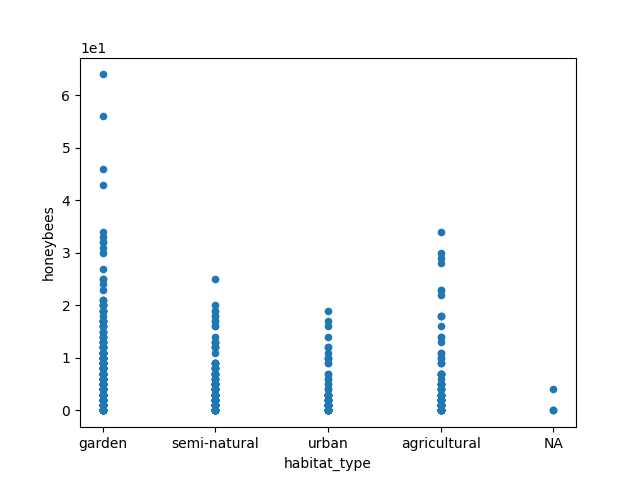

In [89]:
sample_data.plot.scatter('habitat_type', 'honeybees')

sample_id  country        date  year X1km_square sample_projection  \
0   3501506  England  05/05/2018  2018      SK3648              OSGB   
1   3493125  England  05/05/2018  2018      SK9482              OSGB   
2   3455170  England  05/05/2018  2018      SP0380              OSGB   
3   3455025  England  05/05/2018  2018      ST3109              OSGB   
4   3501609  England  19/05/2018  2018      SK3648              OSGB   

  digitised_by                                      recorder_type  \
0        86644  I am familiar with recognising the main groups...   
1       154133  I am familiar with identifying some wildlife g...   
2        73313  I am familiar with recognising the main groups...   
3       156295  I am familiar with recognising the main groups...   
4        86644  I am familiar with recognising the main groups...   

                                     habitat habitat_other_detail  \
0                                     Garden                   NA   
1                                     Garden                   NA   
2                                     Garden                   NA   
3  Grassland with wild flowers (e.g. meadow)                   NA   
4                                     Garden                   NA   

                      target_flower           target_flower_corrected  \
0  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   
1              Hawthorn - Crataegus              Hawthorn - Crataegus   
2     Other - please describe below     Other - please describe below   
3    Buttercup (Ranunculus species)    Buttercup (Ranunculus species)   
4  Dandelion - Taraxacum officinale  Dandelion - Taraxacum officinale   

  target_other_name target_other_name_corrected target_flower_family  \
0                NA                          NA           Asteraceae   
1                NA                          NA             Rosaceae   
2        Pulmonaria                  Pulmonaria         Boraginaceae   
3                NA                          NA        Ranunculaceae   
4                NA                          NA           Asteraceae   

                                   flower_cover floral_unit_count  \
0  Target flowers cover less than half of patch                 6   
1      Target flowers cover about half of patch                22   
2      Target flowers cover about half of patch                15   
3  Target flowers cover less than half of patch                10   
4  Target flowers cover less than half of patch                 1   

         floral_unit                                     flower_context  \
0        flower head       Growing in a larger patch of the same flower   
1  individual flower       Growing in a larger patch of the same flower   
2  individual flower  Growing in a larger patch of many different fl...   
3  individual flower       Growing in a larger patch of the same flower   
4        flower head                              More or less isolated   

  count_start_time               cloud_cover                         sunshine  \
0            11:55        All or mostly blue             Entirely in sunshine   
1            15:01        All or mostly blue             Entirely in sunshine   
2            15:47        All or mostly blue  Partly in sun and partly shaded   
3            14:36  Half blue and half cloud             Entirely in sunshine   
4            12:18  Half blue and half cloud             Entirely in sunshine   

                          wind_speed    enjoyment difficulty  habitat_type  \
0  Leaves moving gently all the time          Fun  Very easy        garden   
1  Leaves moving gently all the time  Really fun!       Okay        garden   
2   Leaves still/moving occasionally         Okay       Easy        garden   
3  Leaves moving gently all the time           NA         NA  semi-natural   
4   Leaves still/moving occasionally          Fun  Very easy        garden   

  flower_structure  bumblebees  honeybees  so

In [38]:
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=0, shuffle=False)

In [41]:
y.shape

(100,)

In [40]:
X.shape

(100, 4)

In [18]:
# Get relevant layers for UK covariates and whack together an SDM workflow,  or just use the variables contained in the UK PoMS data


In [20]:
# Need to think about evaluation metrics

# Build a simple SDM

In [351]:
# Vector processing
import geopandas as gpd
import shapely

# Raster processing
import rasterio
import rasterio.plot
import rasterio.features
import rasterio.sample
from rasterio import windows

# Calcs and modelling
import numpy as np
import pandas as pd
from scipy.stats import zscore
import sklearn
from sklearn import model_selection
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import elapid as ela

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns
import geoplot as gplt

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
import glob
import warnings
from tqdm import tqdm
from ast import literal_eval

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [352]:
WORKING_CRS

CRS.from_epsg(27700)

In [504]:
# Bio var mappings
bio_vars = {
    'bio_19': 'precipitation of coldest quarter', 
    'bio_18': 'precipitation of warmest quarter',
    'bio_15': 'precipitation seasonality (coefficient   of   variation)',
    'bio_12': 'annual precipitation',
    'bio_8': 'mean temperature  of  wettest  quarter',
    'bio_9': 'mean temperature of driest quarter',
    'bio_5': 'maximum temperature of warmest period',
    'bio_6': 'minimum temperature of coldest period',
    'bio_4': 'temperature season-ality  (coefficient  of  variation)',
    'bio_1':  'annual mean temperature',
    'elev': 'SRTM elevation'
}


In [505]:
loc_index = sample_data.drop_duplicates(subset='X1km_square').index
loc_coords = np.vstack([sample_data.loc[loc_index, 'geometry'].x, sample_data.loc[loc_index, 'geometry'].y]).T

bio_samples = {}

# For each biovar get its value at the occurrence record locations
bio_var_paths = []
for bio_var in bio_vars:
    try:
        path = glob.glob('../../../data/SDM_data/covar/epsg_27700/*' + bio_var + '_England*.tif', recursive=False)[0]
    except:
        continue
    bio_var_paths.append(path)
    with rasterio.open(path) as rio_ds:
        bio_samples[bio_var] = np.array(list(rasterio.sample.sample_gen(rio_ds, 
                                                                          loc_coords, 
                                                                          indexes=1, 
                                                                          masked=False))).flatten() 
        
        nodata_val, ref_shape, ref_bounds, ref_profile = rio_ds.nodata, rio_ds.shape, rio_ds.bounds, rio_ds.profile

        

# Clean no_data values 
bio_sample_df = pd.DataFrame(bio_samples, index=loc_index)
bio_sample_df = bio_sample_df[~(bio_sample_df == nodata_val).any(axis=1)]

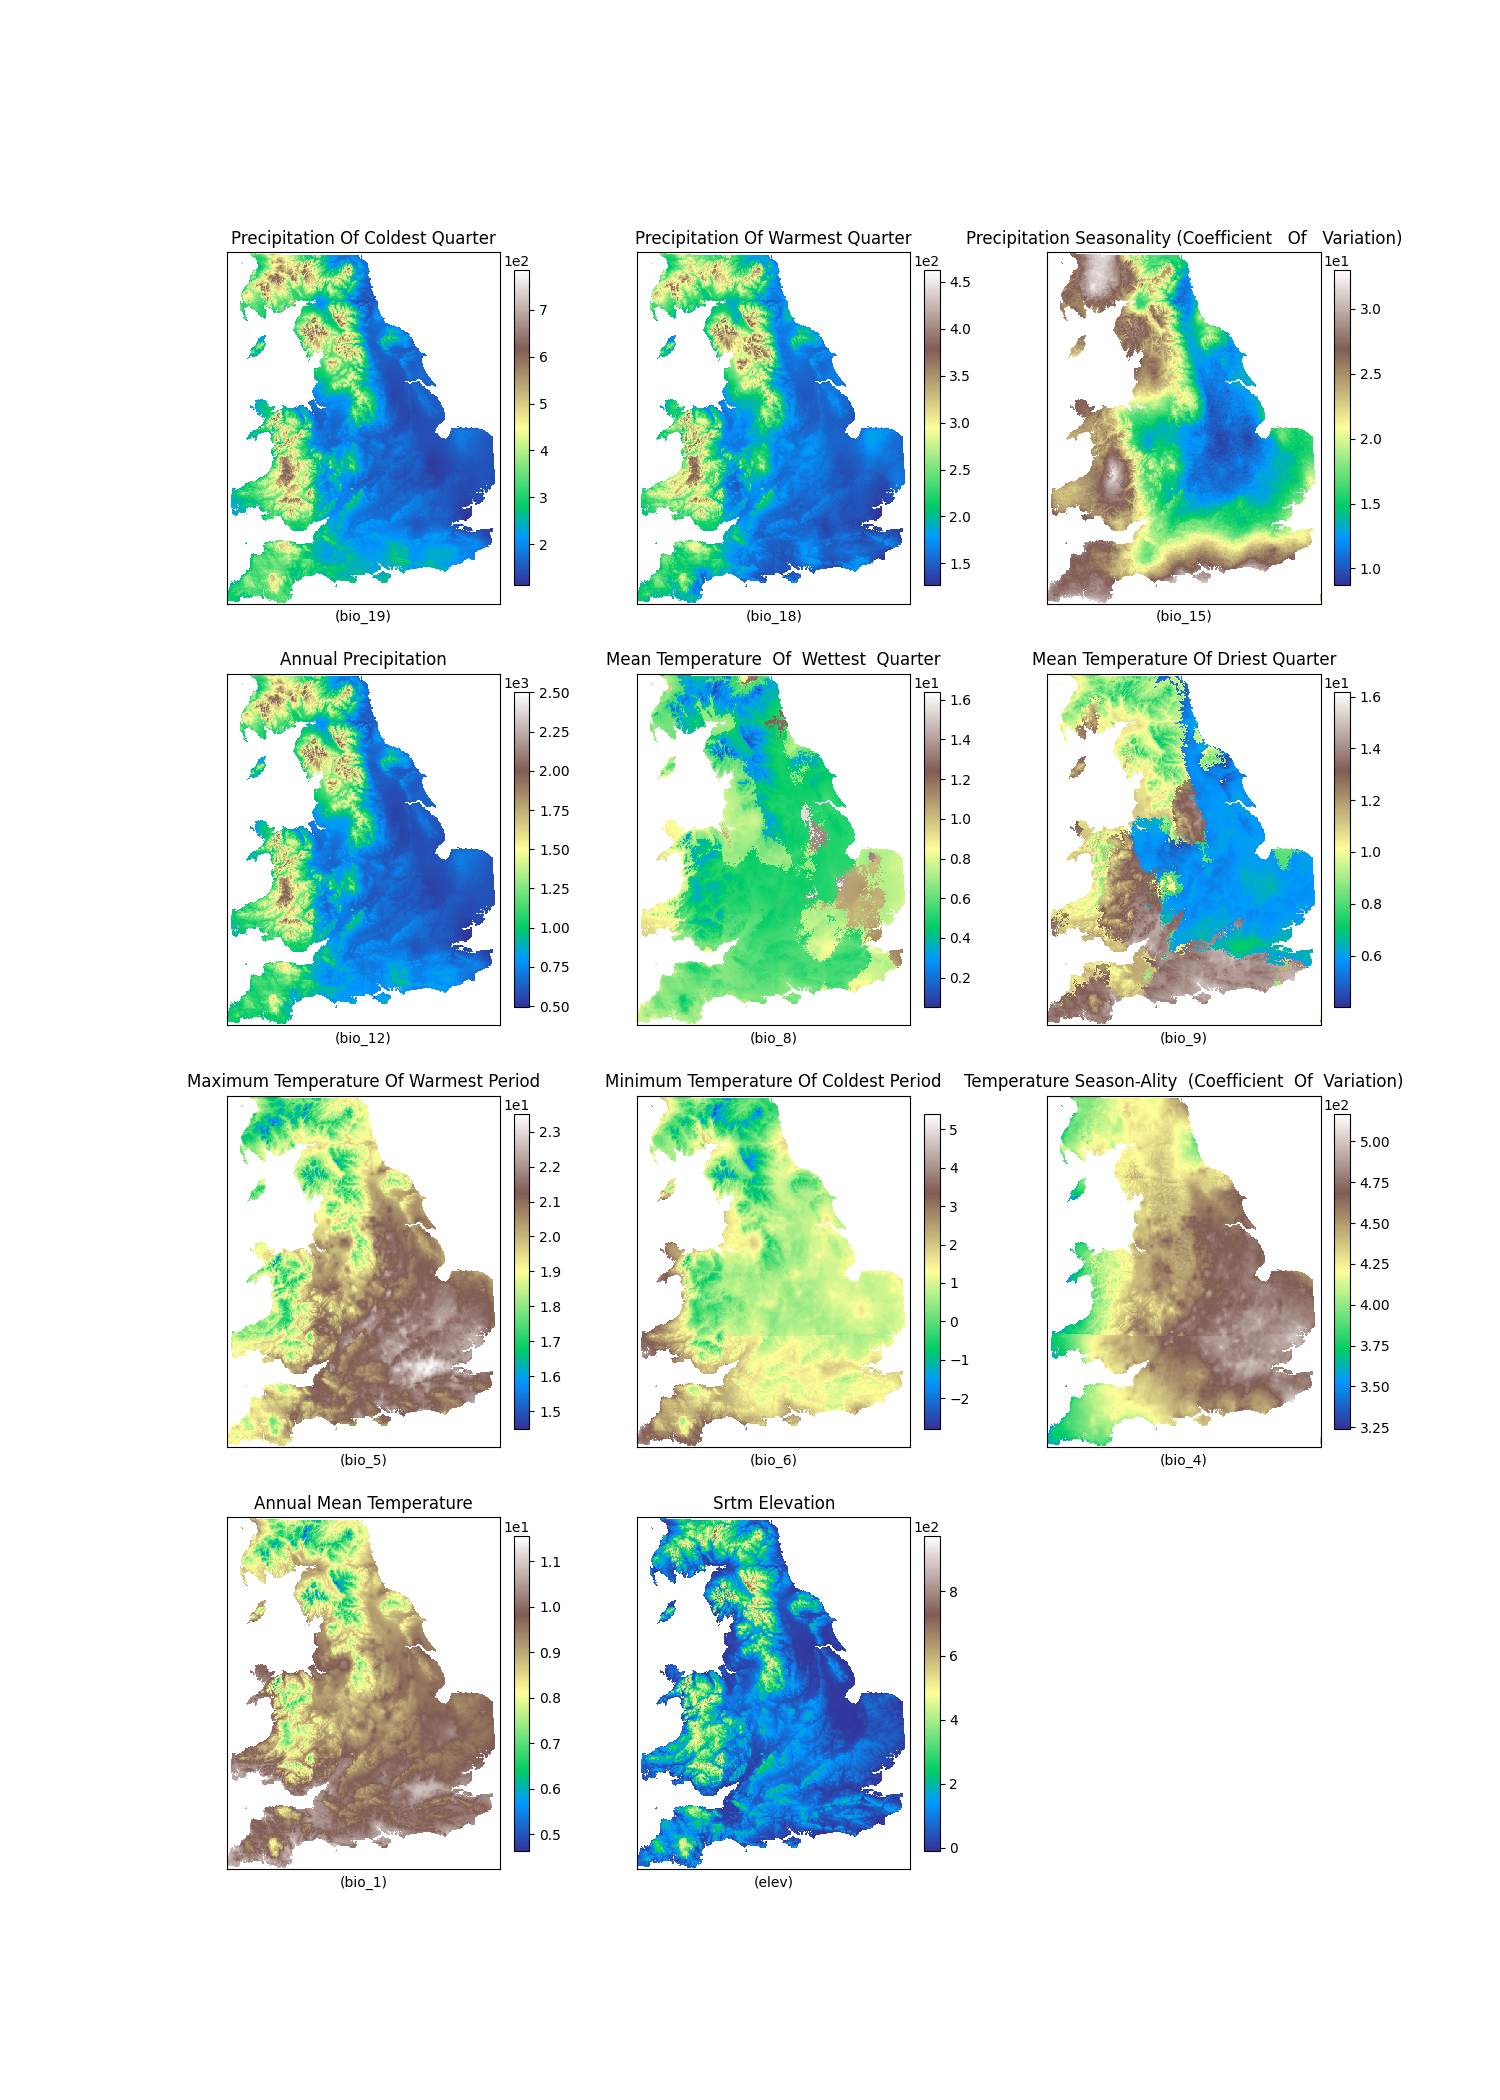

In [506]:
fig, axs = plt.subplots( nrows=4, ncols=3, figsize=(FIGSIZE[0]*3/2, FIGSIZE[1]*6/2))

for fp, name, ax in zip(bio_var_paths, bio_vars, axs.ravel()):
    with rasterio.open(fp) as file:
        output=file.read(1)
        mask=file.read_masks(1)

    im = ax.imshow(np.where(mask == 0, np.nan, output), 
                   cmap='terrain', 
                   extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                  )
    
    # occ_data.plot(ax=ax, markersize=5, color='k', marker='^', label='Occurrence records')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, -0.05, f'({name})', horizontalalignment='center', transform=ax.transAxes)
    fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    ax.set_title(bio_vars[name].title(), wrap=True)

axs[-1, -1].set_axis_off()
# fig.tight_layout()
plt.show()

In [507]:
to_drop = ['bio_8', 'bio_9', 'bio_18', 'bio_19']

bio_sample_df.drop(columns=to_drop, inplace=True)
[bio_vars.pop(k) for k in to_drop]

['mean temperature  of  wettest  quarter',
 'mean temperature of driest quarter',
 'precipitation of warmest quarter',
 'precipitation of coldest quarter']

In [508]:
bio_sample_df_norm = bio_sample_df.apply(zscore)
base_pca = sklearn.decomposition.PCA(n_components=3)
base_pca.fit_transform(bio_sample_df_norm)

print('Percentage of variance explained by PC1, PC2 and PC3 respectively:')
print(base_pca.explained_variance_ratio_)

Percentage of variance explained by PC1, PC2 and PC3 respectively:
[0.48816019 0.3326769  0.10248201]


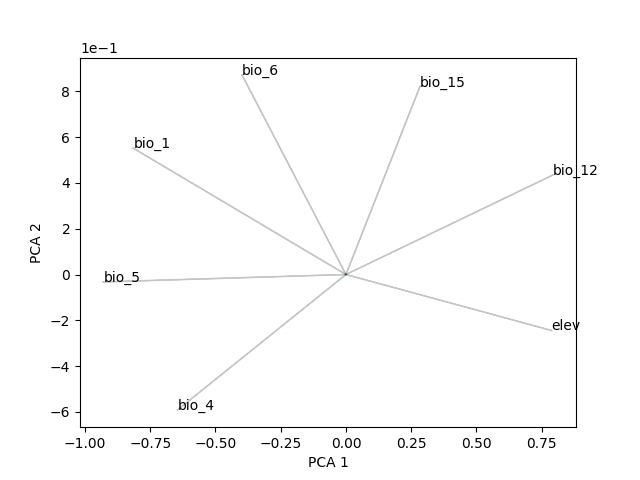

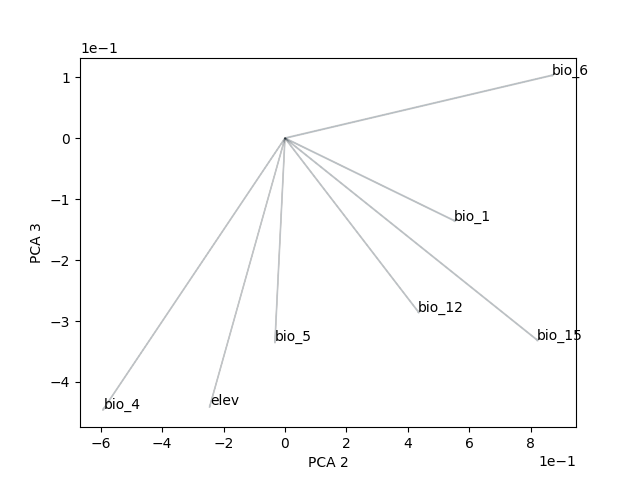

In [509]:
for pc_pair in [[1, 2], [2, 3]]: #, [1, 3]]:
    plt.figure()
    ax = plt.gca()
    for (x, y), label in zip(base_pca.components_.T[:, [pc_pair[0] - 1, pc_pair[1] -1]] * np.sqrt(base_pca.explained_variance_[[pc_pair[0] - 1, pc_pair[1] -1]]), 
                             bio_sample_df_norm.columns):
        plt.arrow(0, 0, x, y, alpha=0.2)
        plt.text(x, y, label)
    
    plt.xlabel('PCA {}'.format(pc_pair[0]))
    plt.ylabel('PCA {}'.format(pc_pair[1]))
    plt.show()

In [510]:
corr_matrix = bio_sample_df.corr(method='spearman')

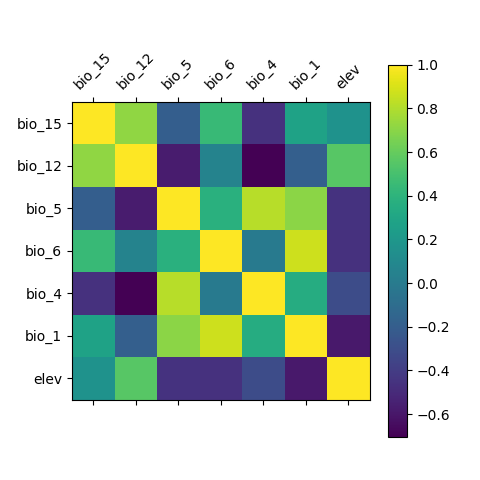

In [511]:
tick_pos = np.array(range(len(corr_matrix)))
plt.matshow(corr_matrix)
plt.xticks(tick_pos, corr_matrix.columns.values, rotation=45)
plt.yticks(tick_pos, corr_matrix.index.values)
plt.colorbar()
plt.show()

In [512]:
corr_pairs = (corr_matrix.abs() > 0.8).unstack()[np.triu(np.ones(corr_matrix.shape)).astype('bool').reshape(corr_matrix.size)]
corr_pairs = [pair for pair in corr_pairs[corr_pairs].index.values if pair[0] != pair[1]]
corr_pairs

[('bio_5', 'bio_4'), ('bio_6', 'bio_1')]

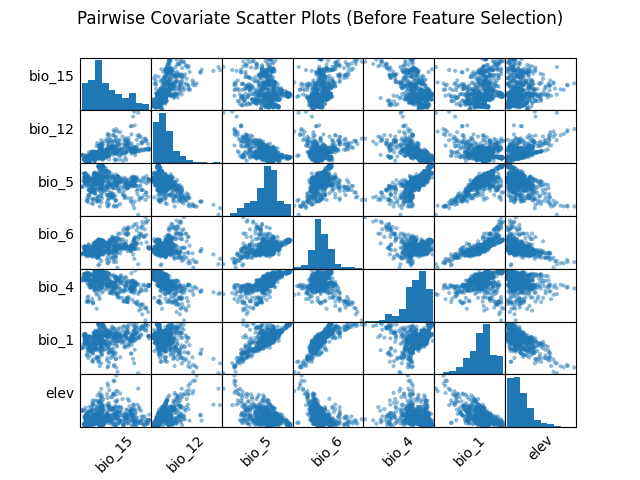

In [513]:
axs = pd.plotting.scatter_matrix(bio_sample_df)
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Pairwise Covariate Scatter Plots (Before Feature Selection)')
plt.show()

In [514]:
covar_contributions = dict(zip(bio_sample_df_norm.columns.to_list(), 
                               np.linalg.norm(base_pca.components_.T * np.sqrt(base_pca.explained_variance_), 
                                              axis=1)))
display(covar_contributions)
to_drop = list(set([sorted(pair, key=lambda x: covar_contributions[x])[0] for pair in corr_pairs]))

{'bio_15': 0.9292739102413199,
 'bio_12': 0.9462481292179462,
 'bio_5': 0.9864520701724947,
 'bio_6': 0.9623093711905266,
 'bio_4': 0.9804554736567227,
 'bio_1': 0.9926125174112785,
 'elev': 0.9325999180354717}

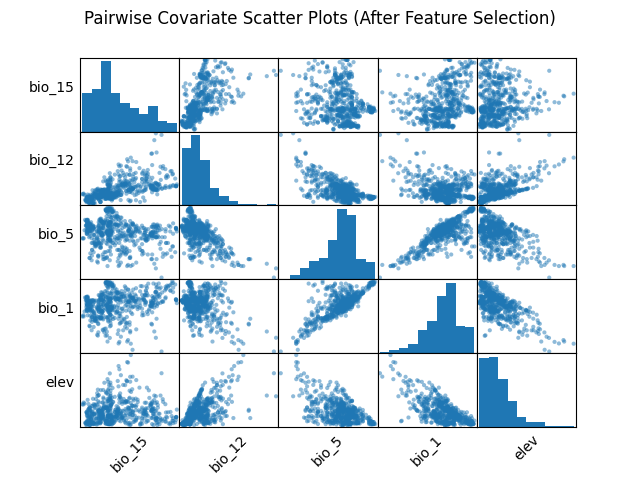

In [515]:
axs = pd.plotting.scatter_matrix(bio_sample_df.drop(columns=to_drop))
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Pairwise Covariate Scatter Plots (After Feature Selection)')
plt.show()

In [516]:
to_drop

['bio_4', 'bio_6']

In [517]:
bio_sample_df.drop(columns=to_drop, inplace=True)
[bio_vars.pop(k) for k in to_drop]

['temperature season-ality  (coefficient  of  variation)',
 'minimum temperature of coldest period']

In [518]:
bio_vars

{'bio_15': 'precipitation seasonality (coefficient   of   variation)',
 'bio_12': 'annual precipitation',
 'bio_5': 'maximum temperature of warmest period',
 'bio_1': 'annual mean temperature',
 'elev': 'SRTM elevation'}

In [519]:
bio_var_paths = [i for i in bio_var_paths if i.split('/')[-1].split('_')[-2] in [i.split('_')[-1] for i in bio_vars]]

In [520]:
bio_sample_df = bio_sample_df.join(sample_data[['X1km_square']]).merge(sample_data.reset_index()[['index', 'X1km_square', 'honeybees', 'sample_weight']], how='outer', on='X1km_square').dropna() # dropna for those locations where the climate covar is undefined (there are only 10 such locations)

### Build RF model

In [521]:
bio_sample_df[bio_sample_df['honeybees'] > 0][['honeybees']].describe(percentiles=[0,0.05, 0.5, 0.95, 1])

honeybees
count  954.000000
mean     5.023061
std      6.238483
min      1.000000
0%       1.000000
5%       1.000000
50%      3.000000
95%     17.000000
100%    64.000000
max     64.000000

In [522]:
filtered_bio_sample_df = bio_sample_df[(bio_sample_df['honeybees'] < 17) & (bio_sample_df['honeybees'] > 0)]

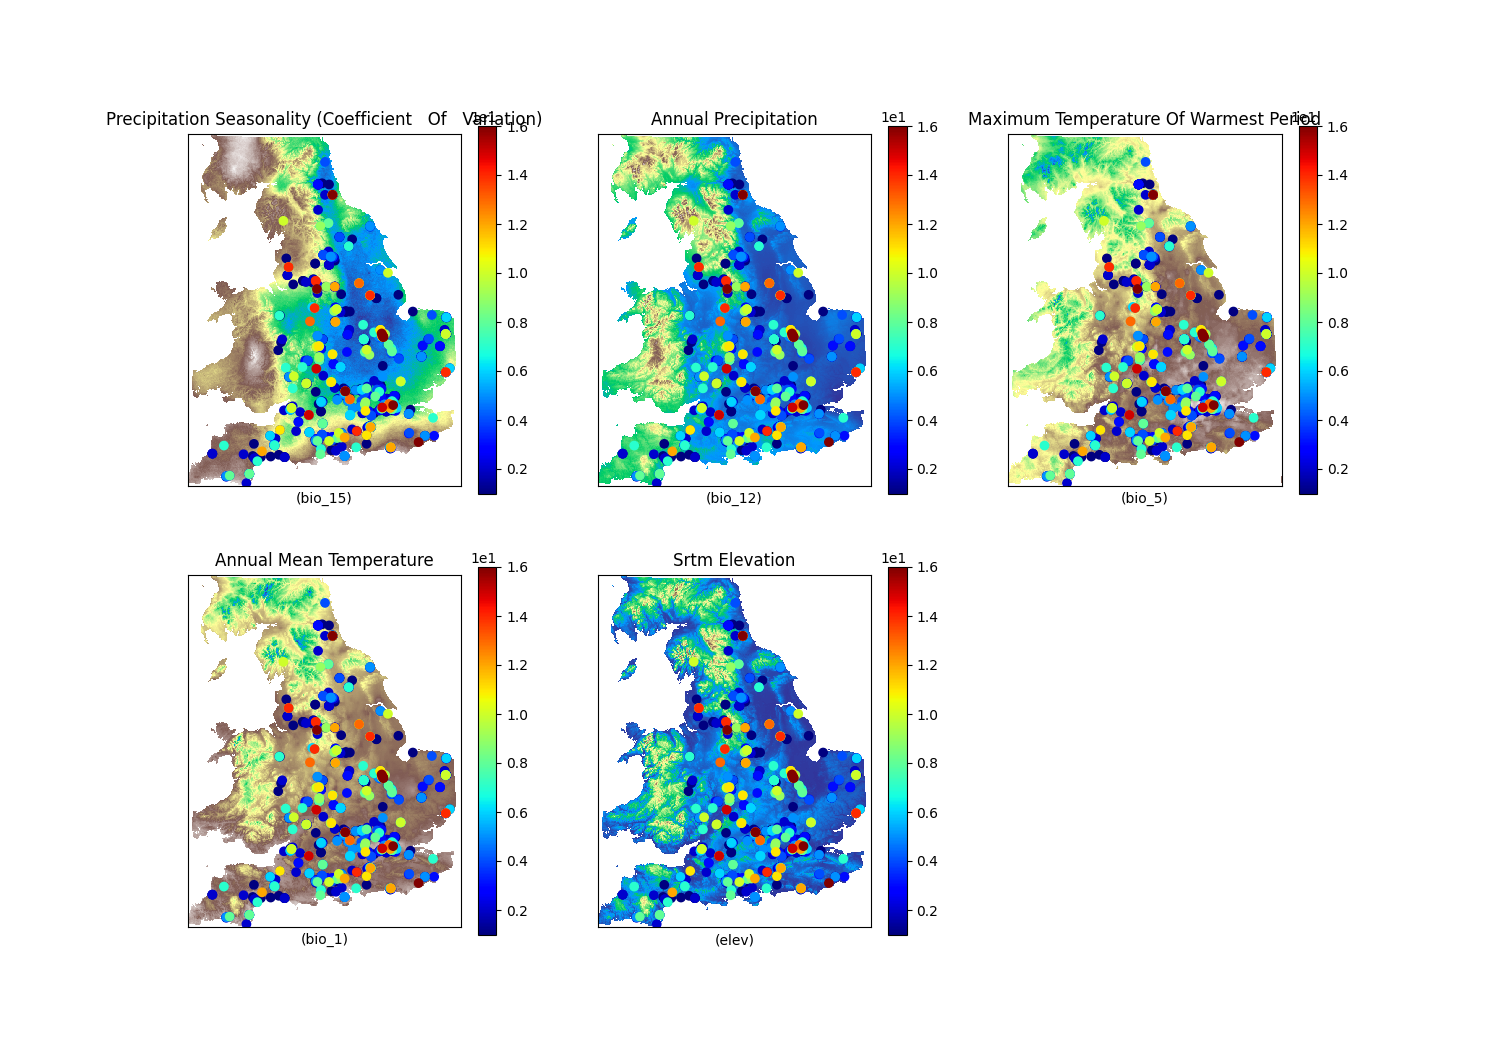

In [589]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(FIGSIZE[0]*3/2, FIGSIZE[1]*3/2), sharex=True, sharey=True)

for fp, name, ax in zip(bio_var_paths, bio_vars, axs.ravel()):
    with rasterio.open(fp) as file:
        output=file.read(1)
        mask=file.read_masks(1)

    im = ax.imshow(np.where(mask == 0, np.nan, output), 
                   cmap='terrain', 
                   extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                  )
    
    sample_data.loc[filtered_bio_sample_df['index'], :].sort_values('honeybees').plot(ax=ax, legend=True, column='honeybees', cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, -0.05, f'({name})', horizontalalignment='center', transform=ax.transAxes)
    # fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    ax.set_title(bio_vars[name].title(), wrap=True)

axs[-1, -1].set_axis_off()
# fig.tight_layout()
plt.show()

In [524]:
##### Set up test, train features and targets #####
X = filtered_bio_sample_df[['bio_15', 'bio_12', 'bio_5', 'bio_1', 'elev']]
y = filtered_bio_sample_df[['honeybees']].rename(columns={'honeybees': 'target'}).apply(np.log1p)
# y = filtered_bio_sample_df[['honeybees']].rename(columns={'honeybees': 'target'})

# Normalization
X_mean = X.mean()
X_std = X.std()

full_range = np.ones(ref_shape, dtype=bool)

def norm_covs(cov, i):
    return cov
    # return (cov - X_mean[i]) / X_std[i]

X_norm = (X - X_mean) / X_std 

In [426]:

n_estimators = 500
for min_samples_split in [2, 5, 20]:
    for max_depth in [5, 10, 50]:
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   random_state=0)
        
        # rf.fit(X_norm, y, sample_weight=filtered_bio_sample_df['sample_weight'].values)
        rf.fit(X, y, sample_weight=filtered_bio_sample_df['sample_weight'].values)
        
        # Apply to full study area using windowed read
        with rasterio.open(bio_var_paths[0]) as src:
            feature_windows = [_wind for _, _wind in src.block_windows(1)]
        
        n = 100
        feature_windows = [windows.union(*feature_windows[i:i + n]) for i in range(0, len(feature_windows), n)]
        write_path = '../../../data/SDM_data/models_bee/{}.tif'.format(f'RF__max_depth_{str(rf.max_depth).zfill(3)}__n_estimators_{str(rf.n_estimators).zfill(3)}__min_samples_split_{str(rf.min_samples_split).zfill(2)}')
        write_dataset = rasterio.open(write_path, 'w+', **ref_profile)
        
        for feature_window in tqdm(feature_windows):
            row_slice, col_slice = feature_window.toslices()
            _reads = []
            _masks = [full_range[row_slice, col_slice]] # only compute where necessary
            
            # Get the covariates in this window
            for i, bio_var_path in enumerate(bio_var_paths):
                with rasterio.open(bio_var_path) as src:
                    _reads.append(norm_covs(src.read(1, window=feature_window), i)) # Models are trained on normalised inputs, so predictions must be generated on the same
                    _masks.append(src.read_masks(1, window=feature_window))    
            _reads = np.stack(_reads, axis=2)      
            _masks = np.logical_and.reduce(_masks)
        
            # Run each model prediction and write to file
            _output = np.empty(_masks.shape)
            _output[:] = np.nan
            if not (~_masks).all():
                _output[_masks] = np.expm1(rf.predict(_reads[_masks]))
                # _output[_masks] = rf.predict(_reads[_masks])
        
            # Save results
            write_dataset.write(_output, window=feature_window, indexes=1)
    
        write_dataset.close()

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


In [458]:
def scaled_mean_abs_error(estimator, X, y):
    _y = y.values.reshape(-1)
    predictions = estimator.predict(X)
    absolute_error = np.abs(predictions - _y) / _y

    return np.mean(absolute_error)


In [496]:
# On a fundamental level we expect to observe a spatial structure dependent on the X1km_square tag (i.e. samples taken in the same 1km grid ref)
# Capturing this information in the CV evaluation process can be achieved with GroupKFold from sklearn
# Note that larger-scale spatial autocorrelation effects are not captured by this grouper

min_samples_split_set = [2, 5, 20]
max_depth_set = [5, 10, 50]
n_estimators_set = [100, 200, 500]

scores = []
max_depths = []
min_samples_splits = []
n_estimatorss = []

for n_estimators in n_estimators_set:
    print('Beginning n_estimators_split: ' + str(n_estimators))
    for min_samples_split in min_samples_split_set:
        print('\tBeginning min_samples_split: ' + str(min_samples_split))
        for max_depth in max_depth_set:
            print('\t\tBeginning max_depth: ' + str(max_depth))
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       random_state=0)
            cv_score = np.mean(cross_val_score(rf, X, y, 
                                               groups=filtered_bio_sample_df['X1km_square'].values, 
                                               scoring=scaled_mean_abs_error,
                                               fit_params={'sample_weight': filtered_bio_sample_df['sample_weight'].values},
                                               cv=GroupKFold()))
            scores.append(cv_score)
            max_depths.append(max_depth)
            min_samples_splits.append(min_samples_split)
            n_estimatorss.append(n_estimators)


    
cv_results = pd.DataFrame({'n_estimators': n_estimatorss, 'max_depth': max_depths, 'min_samples_split': min_samples_splits, 'score': scores})

Beginning n_estimators_split: 100
	Beginning min_samples_split: 2
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
	Beginning min_samples_split: 5
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
	Beginning min_samples_split: 20
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
Beginning n_estimators_split: 200
	Beginning min_samples_split: 2
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
	Beginning min_samples_split: 5
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
	Beginning min_samples_split: 20
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
Beginning n_estimators_split: 500
	Beginning min_samples_split: 2
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
	Beginning min_samples_split: 5
		Beginning max_depth: 5
		Beginning max_depth: 10
		Beginning max_depth: 50
	Beginning min_samples_s

In [499]:
cv_results[cv_results['score'] == cv_results['score'].min()]

n_estimators  max_depth  min_samples_split     score
9           200          5                  2  0.500097

In [500]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=5,
                           min_samples_split=2,
                           random_state=0)

# rf.fit(X_norm, y, sample_weight=filtered_bio_sample_df['sample_weight'].values)
rf.fit(X, y, sample_weight=filtered_bio_sample_df['sample_weight'].values)

# Apply to full study area using windowed read
with rasterio.open(bio_var_paths[0]) as src:
    feature_windows = [_wind for _, _wind in src.block_windows(1)]

n = 100
feature_windows = [windows.union(*feature_windows[i:i + n]) for i in range(0, len(feature_windows), n)]
write_path = '../../../data/SDM_data/models_bee/{}.tif'.format(f'RF__max_depth_{str(rf.max_depth).zfill(3)}__n_estimators_{str(rf.n_estimators).zfill(3)}__min_samples_split_{str(rf.min_samples_split).zfill(2)}')
write_dataset = rasterio.open(write_path, 'w+', **ref_profile)

for feature_window in tqdm(feature_windows):
    row_slice, col_slice = feature_window.toslices()
    _reads = []
    _masks = [full_range[row_slice, col_slice]] # only compute where necessary
    
    # Get the covariates in this window
    for i, bio_var_path in enumerate(bio_var_paths):
        with rasterio.open(bio_var_path) as src:
            _reads.append(norm_covs(src.read(1, window=feature_window), i)) # Models are trained on normalised inputs, so predictions must be generated on the same
            _masks.append(src.read_masks(1, window=feature_window))    
    _reads = np.stack(_reads, axis=2)      
    _masks = np.logical_and.reduce(_masks)

    # Run each model prediction and write to file
    _output = np.empty(_masks.shape)
    _output[:] = np.nan
    if not (~_masks).all():
        _output[_masks] = np.expm1(rf.predict(_reads[_masks]))
        # _output[_masks] = rf.predict(_reads[_masks])

    # Save results
    write_dataset.write(_output, window=feature_window, indexes=1)

write_dataset.close()

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


## Plot results

In [661]:
with rasterio.open(write_path) as file:
    bee_abundance_sdm = np.where(mask == 0, np.nan, file.read(1))


In [662]:
with rasterio.open('../../../data/Agric_data/IYR/data/input_to_yield_ratio_honeybees_epsg_27700_aligned.tiff') as file:
    b_mask=~file.read_masks(1).astype(bool)
    iyr_bees_aligned = np.where(b_mask, np.nan, file.read(1))
    iyr_bees_aligned = rasterio.fill.fillnodata(iyr_bees_aligned, mask=~b_mask, max_search_distance=5)

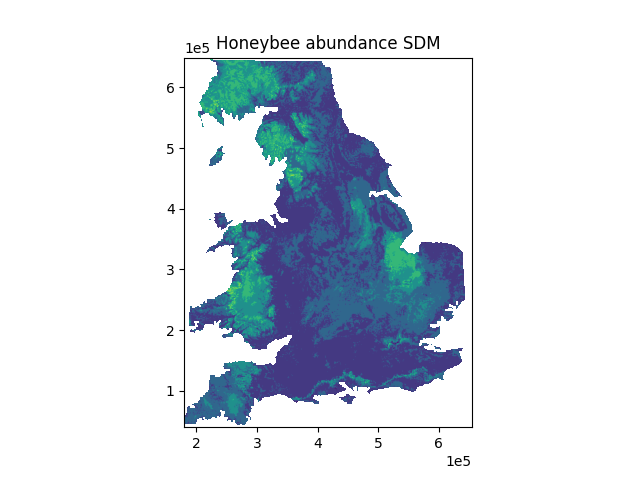

In [732]:
plt.figure()
plt.imshow(bee_abundance_sdm, 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
          interpolation=None)
plt.title('Honeybee abundance SDM')
plt.show()

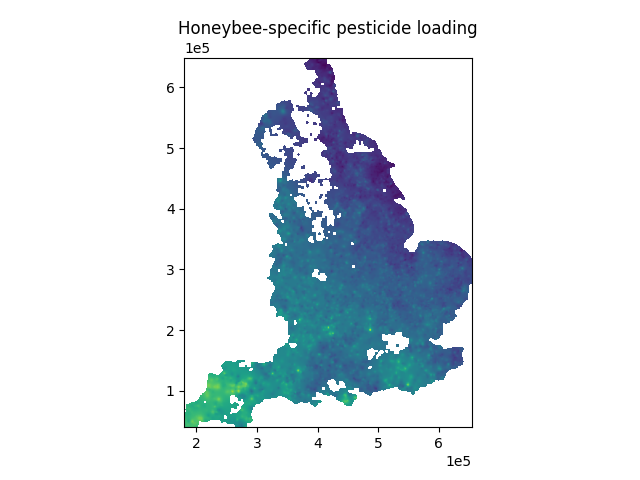

In [663]:
plt.figure()
plt.imshow(iyr_bees_aligned, 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
          interpolation=None)
plt.title('Honeybee-specific pesticide loading')
plt.show()

In [665]:
def rescale_0_1(array):
    max_val = np.nanmax(array)
    min_val = np.nanmin(array)

    result = (array - min_val) / (max_val - min_val)

    return result

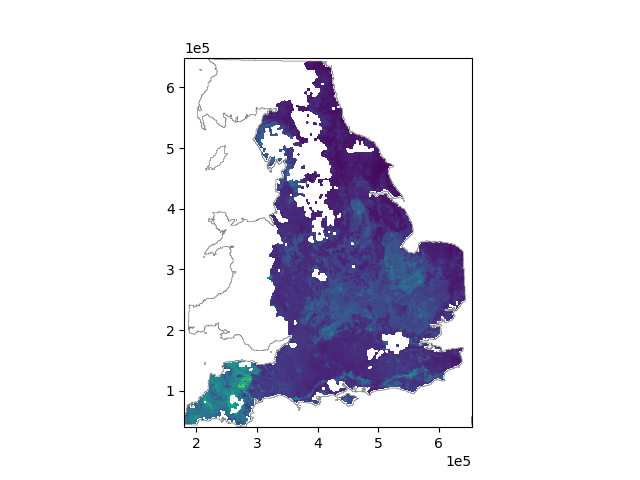

In [711]:
fig, ax = plt.subplots()
ax.imshow(rescale_0_1(iyr_bees_aligned)*rescale_0_1(bee_abundance_sdm), 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
         interpolation=None)

with rasterio.open(bio_var_paths[0]) as file:
    test = gpd.GeoDataFrame.from_features(rasterio.features.dataset_features(file, as_mask=True, geographic=False, band=False), crs=file.crs)

test.geometry.exterior.plot(ax=ax, color='gray', linewidth=0.5)
plt.show()


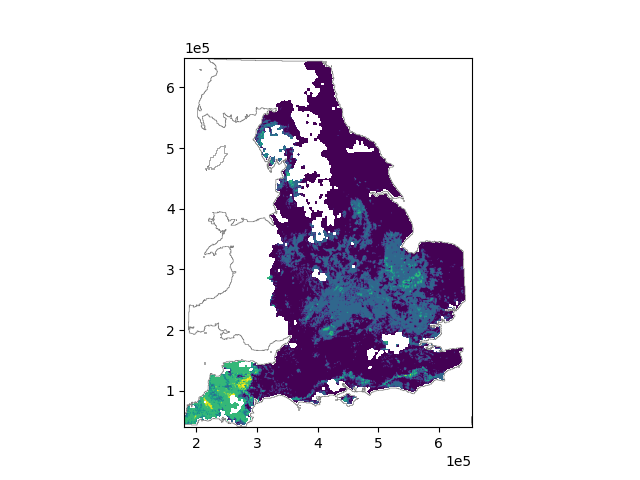

In [731]:
fig, ax = plt.subplots()
scaled = np.digitize(rescale_0_1(iyr_bees_aligned)*rescale_0_1(bee_abundance_sdm), np.logspace(-1,0,num=5))

ax.imshow(np.where(np.isnan(iyr_bees_aligned*bee_abundance_sdm), np.nan, scaled), 
           extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
         interpolation=None)

with rasterio.open(bio_var_paths[0]) as file:
    test = gpd.GeoDataFrame.from_features(rasterio.features.dataset_features(file, as_mask=True, geographic=False, band=False), crs=file.crs)

test.geometry.exterior.plot(ax=ax, color='gray', linewidth=0.5)
plt.show()
